# **Project of IMA201**
Segmentation of skin lesions

*Pedro Andrade and 
Rafael Senna Benatti*

Supervisor: Pietro Gori

This work aims to develop image classification software for the diagnosis of skin lesions such as melanoma and nevus in computer-aided diagnosis systems (CADs). So, our objective is to be able, from a photo containing a skin lesion, to discriminate the pixels of the image which belong or not to the lesional region of the skin. For this, we have a dataset containing 20 dermoscopic images of melanomas and nevi, and we are inspired by the algoritmn that uses Local Bynary Pattern, as we can see in the article Dermoscopic skin lesion image segmentation based on Local Binary Pattern Clustering: Comparative study.

Bellow you can follow our whole pipeline of segmentation.

# The DataSet

The first thing we have to do is to know the Data that we are using. For dataset was available to us two sets of 10 RGB images of melanomas and nevus with the respectives segmentation masks wich will server as truth set of our problem.

Here we can see some examples of images in our datasets.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# This part of the code is meant to retrieve the files from google drive. 
# To retrieve the files you must have created the folder within the melanoma and nevus folder in the directory:
# /content/drive/My Drive/IMA_Segmentation_project/src/images
# Most part of the used libraries are also imported here.
# This was coded by us.

from skimage import io
import os, cv2, re
from matplotlib import pyplot as plt
import numpy as np
# This function returns a list of io images from the group passed as parameter ('melanoma' or 'nevus')
os.chdir("/content/drive/My Drive/IMA_Segmentation_project")

# retrieve_images return an array of images so we can make the segmentation iteratively
def retrieve_images(lesion_type): # Parameter: 'melanoma' or 'nevus'
    im = []
    for f in os.listdir('src/images/' + lesion_type):
        name, extension = os.path.splitext(f)
        try:
            id = str(re.findall("(\d+)$", name)[0])
            image = io.imread('src/images/' + lesion_type + '/ISIC_'+id+'.jpg')
            im.append(image)
        except:
            pass
    return im

In [22]:
# Retrieving the images from both lesion types

# This was coded by us.

im_mel = retrieve_images('melanoma')
im_nev = retrieve_images('nevus')

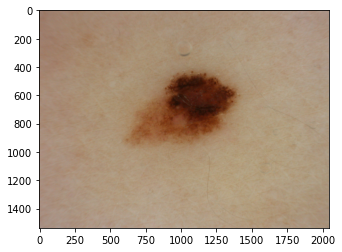

<function matplotlib.pyplot.show(*args, **kw)>

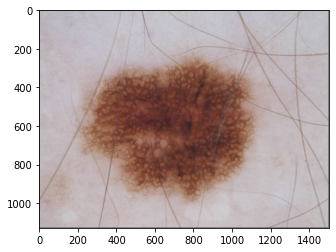

In [23]:
# Ploting the images so we can analyze a bit.

# This was coded by us.

plt.imshow(im_mel[0])
plt.show()
plt.imshow(im_nev[0])
plt.show

As we can observe, the lesions are concentrated in the center of the image and in some examples we can see a circular border arround the skin due to the dermoscopic devices. Also some images present hair in the skin, so we may need to filter it.These are some caracteristics that we need to have in mind when we develop our solution.



Now lets take a look in the segmentation masks already produced.

In [24]:
# This function returns an array of segmented io images from the group passed as parameter ('melanoma' or 'nevus').
# These segmentations were given as labels.

# This was coded by us.

def retrieve_segmentations(lesion_type):
    im = []
    for f in os.listdir('src/images/'+ lesion_type):
        name, extension = os.path.splitext(f)
        id = str(re.findall("\d+", name)[0])
        im.append(io.imread('src/images/' + lesion_type + '/ISIC_'+id+'_Segmentation.png'))
    return im

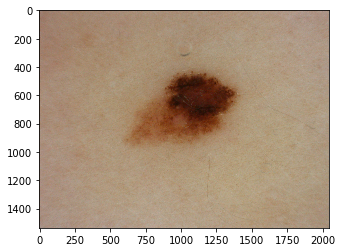

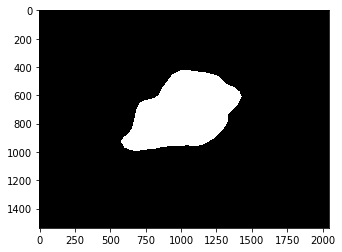

In [25]:
# This was coded by us.

masks_truth = retrieve_segmentations('melanoma')
plt.imshow(im_mel[0], interpolation='nearest')
plt.show()
plt.imshow(masks_truth[0], cmap='gray',interpolation='nearest')
plt.show()

The segmentation consists in one continuos mask. If we take a brief look in the folder we see as well that some of them seem to be constituted of big and rectangyular shapes and others of small polygons. This made us assume that these masks used different kernels to aglutinate the lesion points using a morphological operator.

Based on the reading of the proposed papers, we came up with the following fluxogram for our segmentation.

> This is a genereal fluxogram in which small process aren't presented.

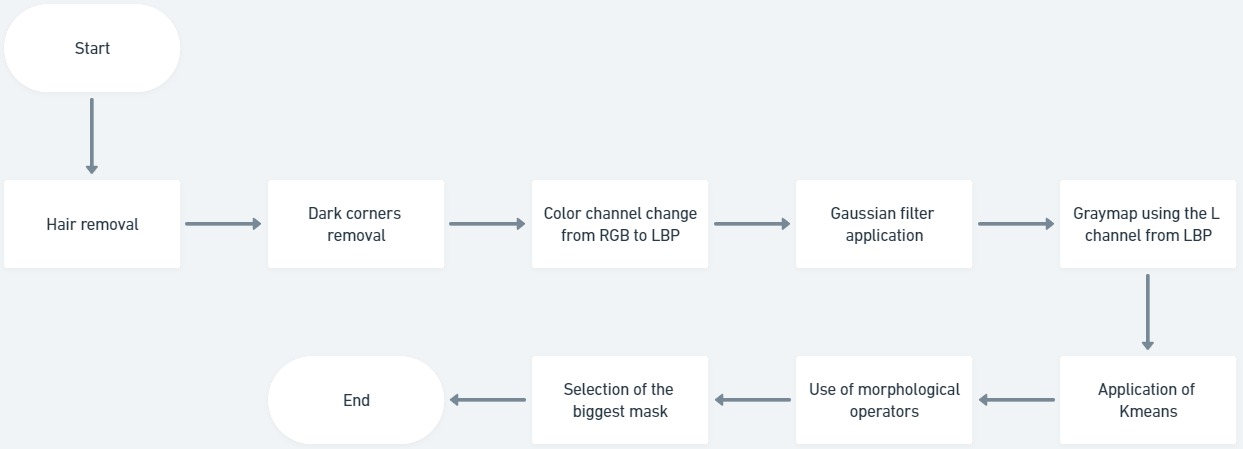

Actually, in the application of Kmeans part we ended up by making some alterations. The KMeans algorithm allows hyperparameters changing by changing the starting point of the calculations. But at some point it didn't work that well for melanoma images, so we used thresholding techniques for melanoma images and KMeans for nevus images.

# Image Preprocessing

For the preprocessing step of our pipeline we have thought in two main preprocessing process that can inprove the already good results that the segmentation process can achieve. First, we have to eliminate the impact that the hairs in the skin can provoke, to do that we have used the algorithm proposed in the article Last but not least, it's necessary to deal with the cases which 
images comes with the dark border of the dermoscopy device, so would be a good 
first step to only apply transformations and segmentations in the Region of interest (ROIs) that we can actually find the leasures, to do that we've localizated dark pixels in the border and gave a paddling in the image accordingly to the size of the dark corner.

The hair removal part is executed first so it's easier to find the dark corners, otherwise the dark pixels of the skin hair could be confused with the dark corners.

*Hair removal*

Following the paper [Dullrazor®: A software approach to hair removal from images](https://gitlab.telecom-paris.fr/Student_Proects/skin_lesion_dataset/-/blob/master/Papers/HaiRemoval/DullRazor.pdf) we used morphological operators within the objective of creating masks for each hair and inpainting it.

In [26]:
# The dullrazor software has several implementations available in python, so we used one of these implementations.
# Before using the code we checked if the procedures followed those proposed in the paper cited above.
# We also made changes in the hyperparameters used here to those that presented the best results for our label images.

from PIL import Image
from skimage.transform import resize

def hair_removal(im):
    # Original image to grayscale
    resizingFactor = 3 # to don't resize, use 1
    img = cv2.resize(im, dsize=(im.shape[0]//resizingFactor, im.shape[1]//resizingFactor), interpolation=cv2.INTER_CUBIC)

    grayScale = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    aux = Image.fromarray(grayScale)
    #aux.show()

    # Kernel for the morph operation
    kernel = cv2.getStructuringElement(1,(15,15))

    # Blackhat to find hair contours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    gaussian= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    # intensify the hair countours
    ret,thresh = cv2.threshold(gaussian,10,255,cv2.THRESH_BINARY)

    # inpaint the original image with masks of hairs
    newimg = cv2.inpaint(img,thresh,5,cv2.INPAINT_TELEA)
    aux = Image.fromarray(newimg)
    #aux.show()

    return newimg


def remove_all(im):
    newim = []
    for img in im:
        newim.append(hair_removal(img))
    return newim

*Border Removal*

The border removal part is really important for this segmentation procediment. If we keep the black corners the KMeans or thresholding technique may recognize these corners as lesion, so, when we execute the morphological operations the corners are concatenated to the lesion and we have a bad segmentation.

In [27]:
# It is used to identify the black corners of the 
# dermoscopy images and return the image with some paddling so we can crop out the black corners

# This was coded by us

paddling = 10

# This function is meant to find the last dark pixel and return a corner point to crop the image
def get_last_dark_pixel(img):
    img = np.asarray(img)
    img = img.astype(float)
    img = img[:, :, 0] * 0.2989 + img[:, :, 1] * 0.5870 + img[:, :, 2] * 0.1140
    
    largest_i = -1
    threshold = 100
    for i in range(0, int(len(img[paddling, :])/2)):
        pixel = img[paddling, i]
        if pixel < threshold :
            largest_i = i

    largest_j = -1
    for j in range(0, int(len(img[:, paddling])/2)):
        pixel = img[j, paddling]
        if pixel < threshold:
            largest_j = j
    # Here we define the corner point to crop the image.
    # We may change the values of 0.8 or 0.1 so we may change the crop format.
    # As one of these values increase, the other must decrease
    return (int(0.1*largest_j), int(0.8*largest_i))

# Here we just crop the image
def crop_image(im, corner):
    # (x0, y0)            (x0, y1)
    #       **************
    #       *            *       
    #       *            *       
    #       *            *       
    #       *            *       
    #       *            *
    #       *            *
    #       **************
    # (x1, y0)            (x1, y1)

    # Some paddling for the images that doesn't big dark corners
    if corner[0] < paddling:
        x0 = paddling * 2
        y0 = paddling
        x1 = len(im[:, 0]) - x0
        y1 = len(im[0, :]) - y0
    else:
        x0 = corner[0]
        y0 = corner[1] 
        x1 = len(im[:, 0]) - x0
        y1 = len(im[0, :]) - y0
    im = im[x0:x1, y0:y1]
    return im

# We pass the array of images as parameter and this function returns the array of cropped images
def retrieve_no_corner_images(img):
    cropped_images = []
    for im in img:
        corner = get_last_dark_pixel(im)
        im = crop_image(im, corner)
        cropped_images.append(im)
    return cropped_images


In [28]:
# Applying both to the arrays
imgs = []
im_mel = remove_all(im_mel)
im_mel = retrieve_no_corner_images(im_mel)

imgs.append(im_nev[9])
im_nev = remove_all(im_nev)
imgs.append(im_nev[9])
im_nev = retrieve_no_corner_images(im_nev)
imgs.append(im_nev[9])

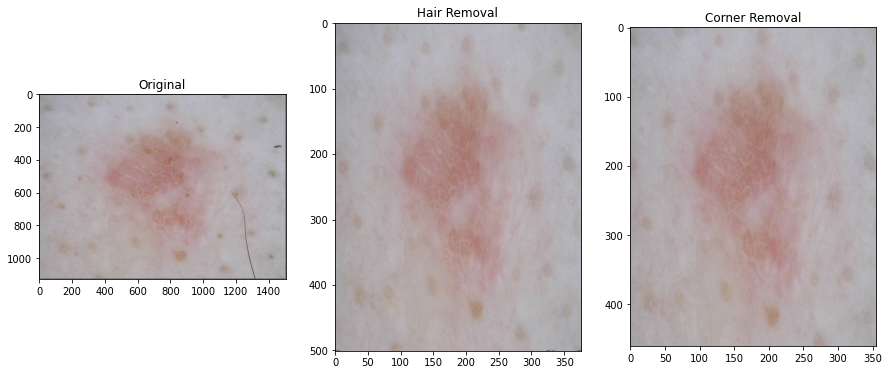

In [29]:
fig,ax = plt.subplots(1, 3, figsize=(15,15))
names = ["Original","Hair Removal","Corner Removal"]
for i in range(3):
  ax[i].set_title(names[i])
  ax[i].imshow(imgs[i],cmap = "gray")

# Segmentation

Now for our main part, we'll implement the segmentation using LBP following the pipeline above.

---



In [ ]:
from skimage import feature
from skimage import filters

In [ ]:
# This function returns a list of the id of the images gro the group passed as parameter

# This code was written by us

def get_id_list(lesion_type): # 'melanoma' or 'nevus'
    id_list = []
    for f in os.listdir('src/images/' + lesion_type):
        name, extension = os.path.splitext(f)
        try:
            id = str(re.findall("(\d+)$", name)[0])
            id_list.append(id)
        except:
            pass

    return id_list

In [ ]:
# Here we're going to define the Local Binary Pattern that we're going to use in our 
# pipeline in addition to an binary LBP and a gaussian filter applied to our result.

# This code was written by us

# This function returns the image in the LBP channel and the image in the grayscale proposed in the paper:
# Accurate Segmentation of Dermoscopic Images based on Local Binary Pattern Clustering
# The paper cited above is cited [6] in the paper that we used as base:
# Dermoscopic skin lesion image segmentation based on Local Binary Pattern Clustering: Comparative study [0]
def lbp(img, r, num):
    img = np.asarray(img)
    img = img.astype(float)
    img = img[:, :, 0] * 0.2989 + img[:, :, 1] * 0.5870 + img[:, :, 2] * 0.1140

    img = img.astype(np.uint8)

    i_min = np.min(img)
    i_max = np.max(img)

    lbp = feature.local_binary_pattern(img, num, r, method='uniform')

    return img, lbp

# Here we just normalize the LBP image 
def binary_lbp(img, r, num):
    Y, lbp_temp = lbp(img, r, num)
    return Y, np.around(lbp_temp/np.max(lbp_temp))

# And finally, we apply an gaussian filter to the image 
def gaussian_lbp(img, r, num):
    Y, lbp = binary_lbp(img, r, num)
    return Y, (filters.gaussian(lbp, sigma=3) * 255)

In [ ]:
# Here we have some helper functions that we are going to use in our segmentation pipeline. 
# Here we first define the methods we use to transform the color space of the image. 
# The Objective here is to improve the discrimination between the two regions to help our algorithm

# This code was written by us 
from skimage import color

# Following the paper [0] we change the result image from the LBP processing to the LAB color space
def lab_color_space(Y, L):
    img = LYL(Y, L)
    img = color.rgb2lab(img)
    return img

# Just reshaping the image
def LYL(Y, L):
    shape = (Y.shape[0], Y.shape[1], 3)
    img = np.empty(shape)
    img[:, :, 0] = L
    img[:, :, 1] = Y
    img[:, :, 2] = L
    return img

# This function was used to separate the chanels ab from L but it's not being used in the main pipeline.
def ab_color_space(Y, L):
    input_image = lab_color_space(Y, L)
    shape = (Y.shape[0], Y.shape[1], 2)
    img = np.empty(shape)
    img[:, :, 0] = input_image[:, :, 1]
    img[:, :, 1] = input_image[:, :, 2]
    return img

In [ ]:
# Here we find an implmentation of KMeans used in our pipeline to cluster the results
# of our segmentation in more meaningful regions.

# This code was used in a TP in IMA201 subject, we made small changes and selected the functions that were important to us
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def recreate_image_colorful(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def kmeans(img, n_class):
    img = np.array(img, dtype=np.float64) / 255
    # Load Image and transform to a 2D numpy array.
    w, h = original_shape = tuple(img.shape)
    d = 1
    image_array = np.reshape(img, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:100]
    kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    img = recreate_image(kmeans.cluster_centers_, labels, w, h)
    return img

def kmeans_colors(img, n_colors):
    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:100]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    img = recreate_image_colorful(kmeans.cluster_centers_, labels, w, h)
    return img

def cluster(img):
    shape = (img.shape[0], img.shape[1])
    X = np.array(img[:, :, 0])
    X.reshape(shape)
    X = (X/np.max(X)).astype(int)
    print(X)
    return X


In [ ]:
# Here we find our main pipeline of the segmentation of one image after the pre-processing process
# This function covers from applying LBP to clustering after kmeans.
# This code was made by us
def main_task(img_array, img_index, lesion_type, plot = 0):
    images = []

    id = get_id_list(lesion_type)
    r = 3
    num = 20 * r

    # This implementation returns the Y scale of the original image without the application of a gaussian filter and
    # the image itself after a LBP, binarization and application of a gaussian filter
    im = img_array[img_index]
    Y, tgaussian_lbp = gaussian_lbp(im, r, num)
    images.append(im)

    # This function returns the LBP treated image in a LAB color space
    lab_image = lab_color_space(Y, tgaussian_lbp)
    images.append(Y)
    threshold = get_l_threshold(lab_image, 0.45) 
    binary = lab_image[:, :, 0] > threshold
    if (lesion_type == 'nevus' and img_index != 7):
      #kmeans
        binary = kmeans(cluster(kmeans_colors(lab_image, 2)), 2)
    resizingFactor = 1 # to don't resize, use 1
    binary = resize(binary, (binary.shape[0]//resizingFactor, binary.shape[1]//resizingFactor))
    images.append(binary)

    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    clustered = cv2.morphologyEx(binary, cv2.MORPH_OPEN, opening_kernel)
    clustered = 1-clustered
    if (lesion_type == 'nevus'):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    clustered = clustered.astype('uint8')

    images.append(clustered)
        # ---------------------- Uncomment this line to apply closure
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_CLOSE, kernel)
    
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40,40))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (70,70))
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_OPEN, opening_kernel)

    images.append(clustered)

    if(plot == 1):
      fig,ax = plt.subplots(1, 5, figsize=(15,15))
      names = ["Original Image","LBP","Morphological opening", "Morphological closure", "Clustered Image"]
      for i in range(5):
        ax[i].set_title(names[i])
        ax[i].imshow(images[i],cmap = "gray")

    plt.imsave('out/'+ lesion_type + '/mask_' + id[img_index] + '.png', clustered, cmap='gray')
    print(f'Saved image with id: {id[img_index]}')    
    im = resize(im, (im.shape[0]//resizingFactor, im.shape[1]//resizingFactor))
    plt.imshow(im, cmap='gray')
    plt.imshow(clustered, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ lesion_type + '/mask_' + id[img_index] + '_superposition.png')

In [ ]:
def lab_cumulative_histogram(im, plotFlag = 1):
    im = im[:, :, 0]
    histo, bin_edges = np.histogram(im, bins=256, range=(0, np.max(im)))
    histo=histo/histo.sum()
    histocum=histo.cumsum()
    if (plotFlag):
        plt.figure()
        plt.title("Histogram")
        plt.xlabel("Value")
        plt.ylabel("pixel count")
        plt.xlim([0.0, np.max(im)])
        plt.plot(bin_edges[0:-1], histocum)
        plt.show()
    return (histocum, bin_edges[0:-1])

# Returns the limit value for a percentage of the histogram
# The pixels within a value below the returned are the darkers
def get_dark_pixels(histo, bins, percentage):
    histo = histo[histo < percentage]
    return bins[len(histo)]

def get_locations_of_pixels_below_x(im, x):
    im = im[:, :, 0]
    return np.nonzero(im < x)

def get_distance_from_center(im, line, column):
    center = (im.shape[0] // 2, im.shape[1] // 2)
    distances = np.zeros(len(line))
    for i in range(0, len(line)):
        distance = ((line[i] - center[0])**2 + (column[i] - center[1])**2)**0.5
        distances[i] = distance
        
    return distances

def get_most_centralized_pixel_value(im, line, column):
    distances = get_distance_from_center(im, line, column)
    index = np.argmin(distances)
    return im[line[index], column[index]]

def get_l_threshold(im, percentage):
    (histocum, bins) = lab_cumulative_histogram(im, plotFlag = 0)
    limit_value = get_dark_pixels(histocum, bins, percentage)
    locations = get_locations_of_pixels_below_x(im, limit_value)
    line = locations[0]
    column = locations[1]
    return limit_value

Saved image with id: 0000151


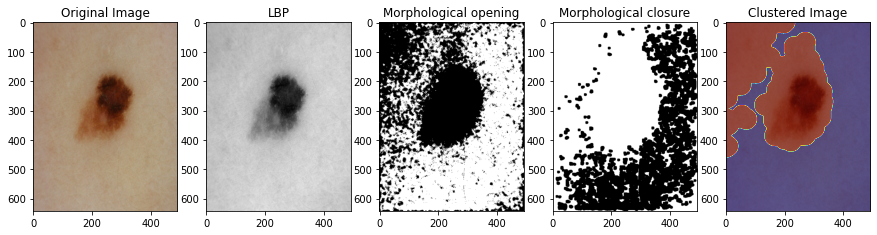

In [ ]:
main_task(im_mel, 1, 'melanoma', 1)

In [ ]:
# Applying to every image
for index in range(0, len(im_mel)):
    
    main_task(im_mel, index, 'melanoma')


In [ ]:
for index in range(0, len(im_nev)):
    print(index)
    main_task(im_nev, index, 'nevus')

In [ ]:
import operator

def CCL(im):
    """ This function takes as input a binary image, searches for all connected objects and returns
        a binary image containg only the biggest connected objects : lesion and background. """

    # Labels matrix : defines the different objects represented with the same label
    labels = np.zeros((im.shape[0]+1,im.shape[1]+2))

    # im1 : the image padded with zeros in order to calculate labels of edge pixels
    im1=np.ones((im.shape[0]+1,im.shape[1]+2))
    im1[1:,1:-1]=im


    # -------- First pass : construct labels matrix -------- #
    labels_num=0 # number of labels
    equiv_L=[] # list of labels that are equivalent i.e. corresponding to the same object 

    # Loop over the image pixels and check if the associated mask contains labels
    for i in range(1,im1.shape[0]) :
        for j in range(1,im1.shape[1]-1):
            if im1[i,j] != 1 : 
                L = [] # list of labels

                # Append labels to L in case a pixel of the mask is equal to the pixel in question
                if im1[i,j-1] == im1[i,j]:
                    L.append(labels[i,j-1])
                if im1[i-1,j-1] == im1[i,j]:
                    L.append(labels[i-1,j-1])
                if im1[i-1,j] == im1[i,j]:
                    L.append(labels[i-1,j])
                if im1[i-1,j+1] == im1[i,j]:
                    L.append(labels[i-1,j+1])

                # In case there are no labels identified, we add a new label to L
                if len(L) == 0:
                    labels_num += 1
                    labels[i,j] = labels_num
                else:
                # In case we find multiple labels, we assign the minimum one to the pixel in question
                # and we consider the found labels as equivalent and associate them to the same group
                    labels[i,j] = min(L)
                equiv_L.append(L)   

                
    # --------------------- second pass --------------------- #

    # Loop over the list of equivalent labels
    # Replace each label with the minimum value of its equivalents
    for l in equiv_L: 
        for i in l :
            labels[labels==i]=min(l)

    
    labels=labels[1:,1:-1]

    
    # ------------ Keep the two biggest regions ------------ #

    # Define a dictionary D that defines labels as keys and the number of associated pixels as values
    D={}
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] in D.keys():
                D[labels[i,j]]+=1
            else :
                D[labels[i,j]]=1

    # Search for the two biggest regions (those with the two maximum values in dictionary D)
    Max_labels=[] # list of the two labels with biggest regions

    # First biggest region
    var=max(D.items(), key=operator.itemgetter(1))[0]
    Max_labels.append(var)
    D[var]=0

    # Second biggest region
    var=max(D.items(), key=operator.itemgetter(1))[0]
    Max_labels.append(var)
    D[var]=0

    # Loop over the image pixels, if the label pixel doesn't figure in Max_labels list assign it as background 
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if labels[i,j] not in Max_labels:
                im[i,j]=1
    return(im)

In [ ]:
# Finally removing extra masks
def remove_masks(img_array, img_index, lesion_type):
  id = get_id_list(lesion_type)
  image = io.imread('out/'+ lesion_type + '/mask_' + id[img_index] + '.png')[:, :, 1]
  image = CCL(image)
  return image

Nevus: 


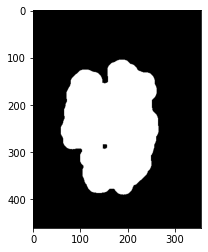

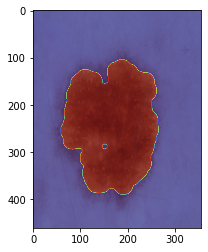

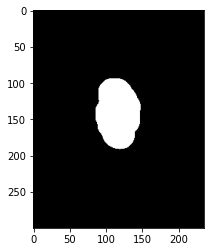

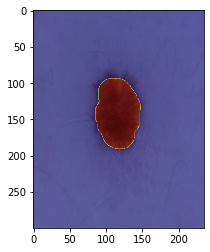

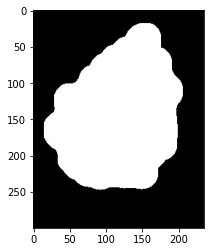

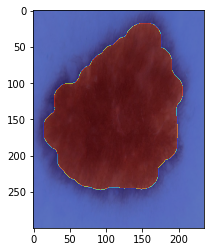

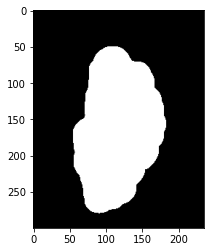

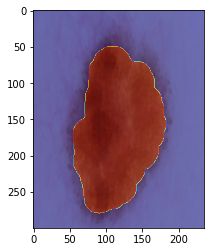

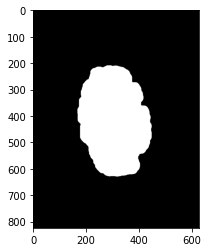

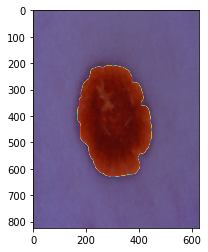

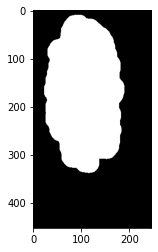

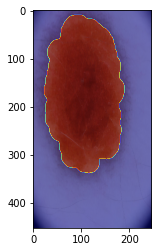

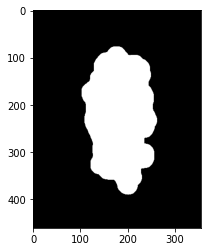

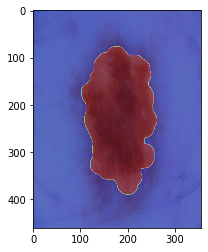

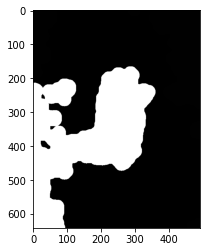

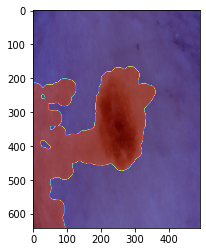

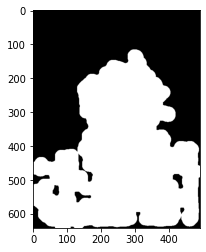

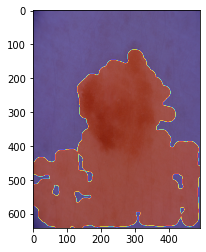

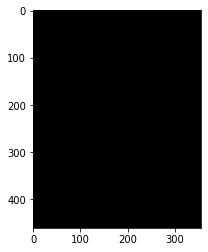

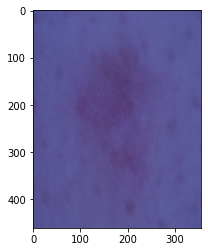

Melanoma: 


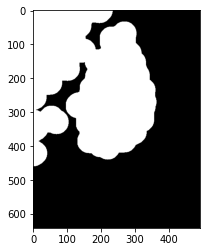

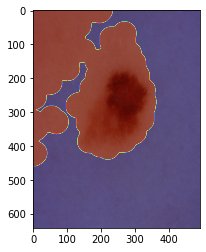

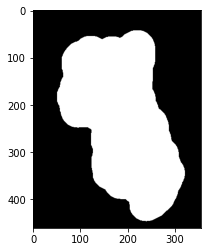

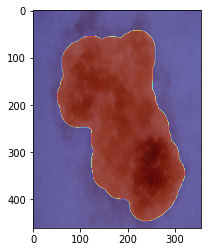

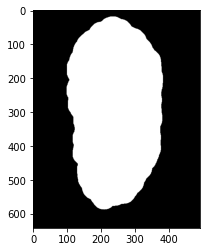

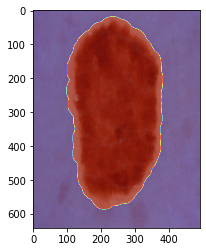

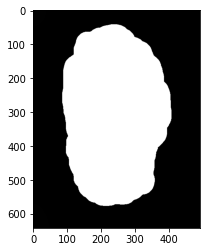

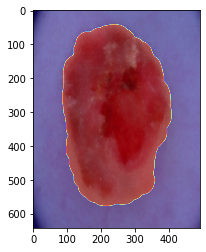

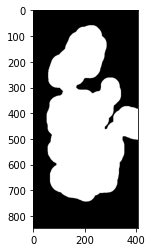

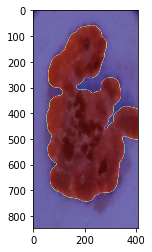

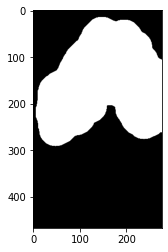

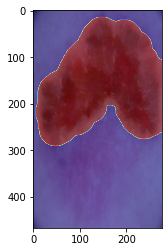

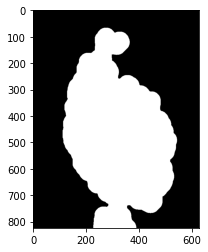

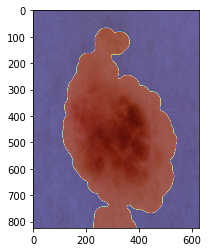

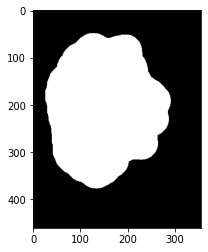

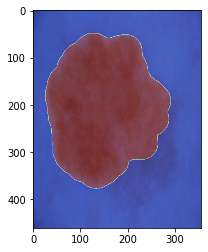

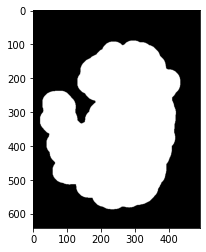

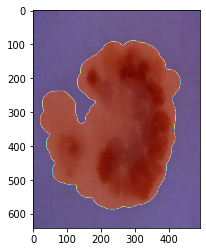

In [ ]:
print('Nevus: ')
id = get_id_list('nevus')
for index in range(0, len(im_nev)):    
    image = remove_masks(im_nev, index, 'nevus')
    plt.imshow(image, cmap='gray')
    plt.imsave('out/'+ 'nevus'+ '/mask_' + id[index] + '_CCL.png', image, cmap='gray')
    plt.show()
    plt.imshow(im_nev[index], cmap='gray')
    plt.imshow(image, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ 'nevus'+ '/mask_' + id[index] + '_CCL_superposition.png')
    plt.show()

id = get_id_list('melanoma')
print('Melanoma: ')
for index in range(0, len(im_mel)):    
    image = remove_masks(im_mel, index, 'melanoma')
    plt.imshow(image, cmap='gray')
    plt.imsave('out/'+ 'melanoma'+ '/mask_' + id[index] + '_CCL.png', image, cmap='gray')
    plt.show()
    plt.imshow(im_mel[index], cmap='gray')
    plt.imshow(image, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ 'melanoma' + '/mask_' + id[index] + '_CCL_superposition.png')
    plt.show()

In [ ]:
# As we can see some images still have some small roles inside the segmentations mask.
# But the biggest problem is: oversized masks, where a big part of the skin is identified as lesion
# Also we have a image that nothing has been identified

# 1. To solve these problems we will start by the oversized masks. We will proceed with a semi-automatic segmentation procedure
# where we ask the user the ID of the oversized masks so we can redo the segmentation process with some different hyperparameters.
# 2. Also, we are going to automatically check whether a lesion was found by checking if there is a mask or not, in the case of not existing a mask we will redo the segmentation.
# 3. After that we will apply a morphological closure to every image so we can close the small holes in an automatic way

## Semi-automatic oversized masks


---

In [30]:
def retrieve_oversized_ids(lesion_type): # 'nevus' or 'melanoma' 
  print("You can easily find damaged segmentations in the directory My Drive/IMA_Segmentation_project/out")
  id_list = get_id_list(lesion_type)
  oversizedMaskID = input("Input the ID of the oversized " + lesion_type + " mask. If none, just press enter: ")
  oversizedMaskIDList = []
  if(id_list.count(oversizedMaskID) and not (oversizedMaskIDList.count(oversizedMaskID))):
    oversizedMaskIDList.append(oversizedMaskID)
  while(oversizedMaskID):
    oversizedMaskID = str(input("Input the ID of the oversized " + lesion_type + " mask. If none, just press enter: "))
    if(id_list.count(oversizedMaskID) and not (oversizedMaskIDList.count(oversizedMaskID))):
      oversizedMaskIDList.append(oversizedMaskID)

  return oversizedMaskIDList

def retrieve_oversized_images(id_list, lesion_type):
  im = []
  for id in id_list:
    image = io.imread('src/images/' + lesion_type + '/ISIC_'+id+'.jpg')
    im.append(image)
  return im

# Here we find our main pipeline of the segmentation of one image after the pre-processing process
# This function covers from applying LBP to clustering after kmeans.
# This code was made by us
plot = 1
def main_task_oversized(im, oversized_id, lesion_type):
    r = 3
    num = 20 * r

    # This implementation returns the Y scale of the original image without the application of a gaussian filter and
    # the image itself after a LBP, binarization and application of a gaussian filter
    Y, tgaussian_lbp = gaussian_lbp(im, r, num)

    # This function returns the LBP treated image in a LAB color space
    lab_image = lab_color_space(Y, tgaussian_lbp)
    threshold = get_l_threshold(lab_image, 0.15) 
    binary = lab_image[:, :, 0] > threshold
    
    if (lesion_type == 'nevus'):
      threshold = get_l_threshold(lab_image, 0.12) 
      binary = lab_image[:, :, 0] > threshold
    
    resizingFactor = 1 # to don't resize, use 1
    binary = resize(binary, (binary.shape[0]//resizingFactor, binary.shape[1]//resizingFactor))
    if plot == 1:
        plt.imshow(binary, cmap='gray')
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    clustered = cv2.morphologyEx(binary, cv2.MORPH_OPEN, opening_kernel)
    clustered = 1-clustered
    if (lesion_type == 'nevus'):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    clustered = clustered.astype('uint8')
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("Before closing")
        plt.show()

        # ---------------------- Uncomment this line to apply closure
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_CLOSE, kernel)
    
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("After closing")
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (80,80))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (70,70))
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_OPEN, opening_kernel)
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.show()
    plt.imsave('out/'+ lesion_type + '/mask_' + oversized_id + '_CCL.png', clustered, cmap='gray')
    print(f'Saved image with id: {id}')    
    im = resize(im, (im.shape[0]//resizingFactor, im.shape[1]//resizingFactor))
    plt.imshow(im, cmap='gray')
    plt.imshow(clustered, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ lesion_type + '/mask_' + oversized_id + 'CCL_superposition.png')
    if plot == 1:
        plt.show()

def main_task_null_mask(im, oversized_id, lesion_type):
    r = 3
    num = 20 * r

    # This implementation returns the Y scale of the original image without the application of a gaussian filter and
    # the image itself after a LBP, binarization and application of a gaussian filter
    Y, tgaussian_lbp = gaussian_lbp(im, r, num)

    # This function returns the LBP treated image in a LAB color space
    lab_image = lab_color_space(Y, tgaussian_lbp)
    threshold = get_l_threshold(lab_image, 0.4) 
    binary = lab_image[:, :, 0] > threshold
    
    if (lesion_type == 'nevus'):
      threshold = get_l_threshold(lab_image, 0.37) 
      binary = lab_image[:, :, 0] > threshold
    
    resizingFactor = 1 # to don't resize, use 1
    binary = resize(binary, (binary.shape[0]//resizingFactor, binary.shape[1]//resizingFactor))
    if plot == 1:
        plt.imshow(binary, cmap='gray')
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    clustered = cv2.morphologyEx(binary, cv2.MORPH_OPEN, opening_kernel)
    clustered = 1-clustered
    if (lesion_type == 'nevus'):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    clustered = clustered.astype('uint8')
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("Before closing")
        plt.show()

        # ---------------------- Uncomment this line to apply closure
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_CLOSE, kernel)
    
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("After closing")
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (80,80))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (70,70))
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_OPEN, opening_kernel)
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.show()
    plt.imsave('out/'+ lesion_type + '/mask_' + oversized_id + '_CCL.png', clustered, cmap='gray')
    print(f'Saved image with id: {id}')    
    im = resize(im, (im.shape[0]//resizingFactor, im.shape[1]//resizingFactor))
    plt.imshow(im, cmap='gray')
    plt.imshow(clustered, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ lesion_type + '/mask_' + oversized_id + '_CCL_superposition.png')
    if plot == 1:
        plt.show()

In [ ]:
oversized_images_IDs_nevus = retrieve_oversized_ids('nevus')
print(oversized_images_IDs_nevus)

You can easily find damaged segmentations in the directory My Drive/IMA_Segmentation_project/out
Input the ID of the oversized nevus mask. If none, just press enter: 0000112
Input the ID of the oversized nevus mask. If none, just press enter: 0000095
Input the ID of the oversized nevus mask. If none, just press enter: 
['0000112', '0000095']


In [ ]:
oversized_images_IDs_melanoma = retrieve_oversized_ids('melanoma')
print(oversized_images_IDs_melanoma)

You can easily find damaged segmentations in the directory My Drive/IMA_Segmentation_project/out
Input the ID of the oversized melanoma mask. If none, just press enter: 0000151
Input the ID of the oversized melanoma mask. If none, just press enter: 0000143
Input the ID of the oversized melanoma mask. If none, just press enter: 
['0000151', '0000143']


In [ ]:
im_oversized_nevus = retrieve_oversized_images(oversized_images_IDs_nevus, 'nevus')
im_oversized_melanoma = retrieve_oversized_images(oversized_images_IDs_melanoma, 'melanoma')

im_oversized_nevus = remove_all(im_oversized_nevus)
im_oversized_nevus = retrieve_no_corner_images(im_oversized_nevus)
im_oversized_melanoma = remove_all(im_oversized_melanoma)
im_oversized_melanoma = retrieve_no_corner_images(im_oversized_melanoma)

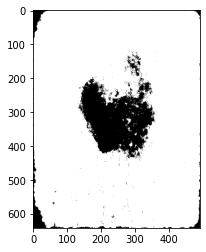

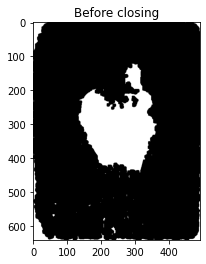

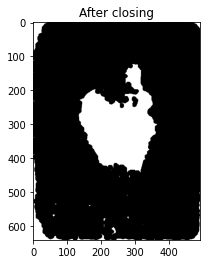

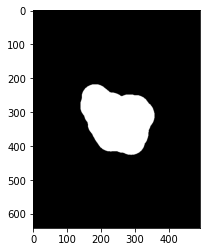

Saved image with id: 0000112


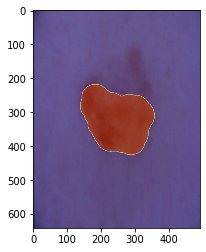

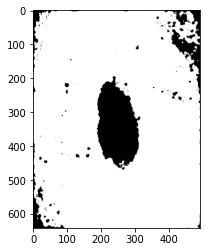

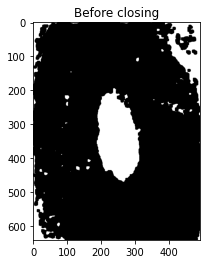

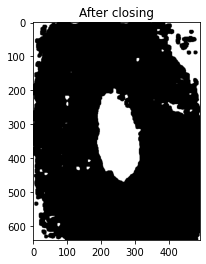

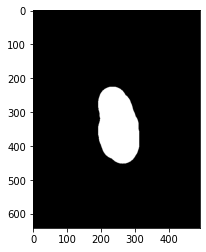

Saved image with id: 0000095


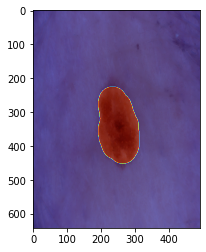

In [ ]:
for i in range(0, len(im_oversized_nevus)):
  image = im_oversized_nevus[i]
  id = oversized_images_IDs_nevus[i]
  lesion_type = 'nevus'
  main_task_oversized(image, id, lesion_type)

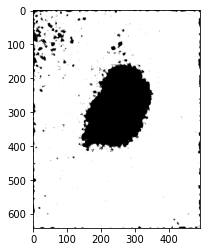

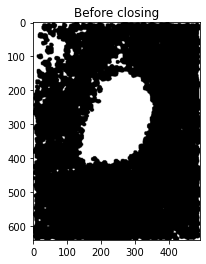

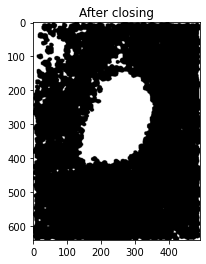

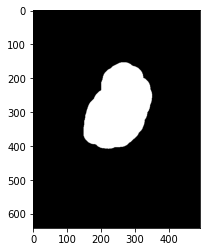

Saved image with id: 0000151


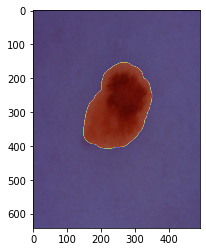

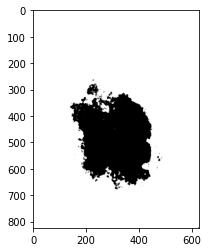

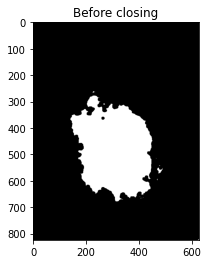

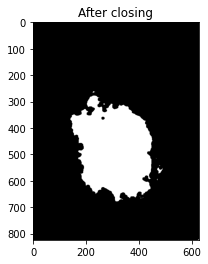

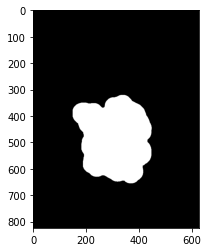

Saved image with id: 0000143


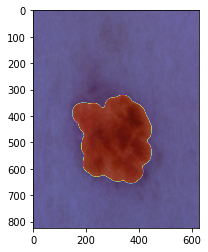

In [ ]:
for i in range(0, len(im_oversized_melanoma)):
  image = im_oversized_melanoma[i]
  id = oversized_images_IDs_melanoma[i]
  lesion_type = 'melanoma'
  main_task_oversized(image, id, lesion_type)

## Automatic 'not found mask' 

---



In [ ]:
plot = 1
def main_task_null_mask(im, oversized_id, lesion_type):
    r = 3
    num = 20 * r

    # This implementation returns the Y scale of the original image without the application of a gaussian filter and
    # the image itself after a LBP, binarization and application of a gaussian filter
    Y, tgaussian_lbp = gaussian_lbp(im, r, num)

    # This function returns the LBP treated image in a LAB color space
    lab_image = lab_color_space(Y, tgaussian_lbp)
    threshold = get_l_threshold(lab_image, 0.4) 
    binary = lab_image[:, :, 0] > threshold
    
    if (lesion_type == 'nevus'):
      threshold = get_l_threshold(lab_image, 0.37) 
      binary = lab_image[:, :, 0] > threshold
    
    resizingFactor = 1 # to don't resize, use 1
    binary = resize(binary, (binary.shape[0]//resizingFactor, binary.shape[1]//resizingFactor))
    if plot == 1:
        plt.imshow(binary, cmap='gray')
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    clustered = cv2.morphologyEx(binary, cv2.MORPH_OPEN, opening_kernel)
    clustered = 1-clustered
    if (lesion_type == 'nevus'):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    clustered = clustered.astype('uint8')
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("Before closing")
        plt.show()

        # ---------------------- Uncomment this line to apply closure
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_CLOSE, kernel)
    
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.title("After closing")
        plt.show()
    if (lesion_type == 'nevus'):
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (80,80))
    else:
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (70,70))
    clustered = cv2.morphologyEx(clustered, cv2.MORPH_OPEN, opening_kernel)
    if plot == 1:
        plt.imshow(clustered, cmap='gray')
        plt.show()
    plt.imsave('out/'+ lesion_type + '/mask_' + oversized_id + '_CCL.png', clustered, cmap='gray')
    print(f'Saved image with id: {id}')    
    im = resize(im, (im.shape[0]//resizingFactor, im.shape[1]//resizingFactor))
    plt.imshow(im, cmap='gray')
    plt.imshow(clustered, cmap='jet', alpha=0.5)
    plt.savefig('out/'+ lesion_type + '/mask_' + oversized_id + '_CCL_superposition.png')
    if plot == 1:
        plt.show()

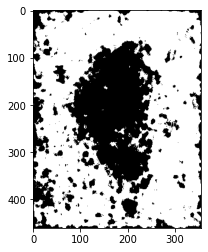

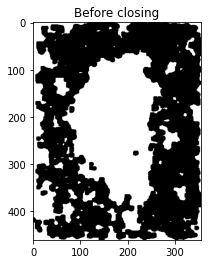

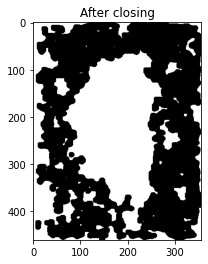

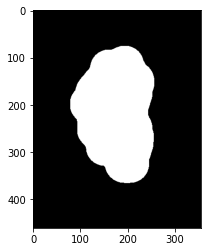

Saved image with id: 0000024


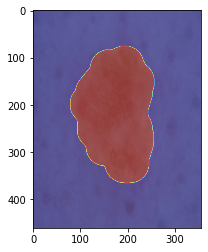

In [ ]:
# Checking for not found masks in nevus output
id = get_id_list('nevus')
null_image_nevus_ID_list = []
null_image_nevus_list = []
for index in range(0, len(im_nev)):    
    image_i = io.imread('out/'+ 'nevus'+ '/mask_' + id[index] + '.png')
    image_i = np.asarray(image_i)[:, :, 0:3]
    if (np.max(image_i) == 0):
      null_image_id = id[index]
      null_image_nevus_ID_list.append(null_image_id)

null_image_nevus_list = retrieve_oversized_images(null_image_nevus_ID_list, 'nevus')
null_image_nevus_list = remove_all(null_image_nevus_list)
null_image_nevus_list = retrieve_no_corner_images(null_image_nevus_list)

for i in range(0, len(null_image_nevus_ID_list)):
  id = null_image_nevus_ID_list[i]
  image = null_image_nevus_list[i]
  main_task_null_mask(image, id, lesion_type)

In [ ]:
# Checking for not found masks in melanoma output
id = get_id_list('melanoma')
null_image_melanoma_ID_list = []
null_image_melanoma_list = []
for index in range(0, len(im_nev)):    
    image_i = io.imread('out/'+ 'melanoma'+ '/mask_' + id[index] + '.png')
    image_i = np.asarray(image_i)[:, :, 0:3]
    if (np.max(image_i) == 0):
      null_image_id = id[index]
      null_image_melanoma_ID_list.append(null_image_id)

null_image_melanoma_list = retrieve_oversized_images(null_image_melanoma_ID_list, 'melanoma')
null_image_melanoma_list = remove_all(null_image_melanoma_list)
null_image_melanoma_list = retrieve_no_corner_images(null_image_melanoma_list)

for i in range(0, len(null_image_melanoma_ID_list)):
  id = null_image_melanoma_ID_list[i]
  image = null_image_melanoma_list[i]
  main_task_null_mask(image, id, lesion_type)

As we can see, there were no null masks in melanoma output.

## Morphological closing


---



In [ ]:
 def apply_closing(lesion_type): 
  id = get_id_list(lesion_type)
  mask_ID_list = []
  mask_list = []
  for index in range(0, len(im_nev)):    
      image_i = io.imread('out/'+ lesion_type + '/mask_' + id[index] + '_CCL.png')
      image_i = np.asarray(image_i)[:, :, 0:3]
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
      image_i = image_i.astype('uint8')
      # ---------------------- Uncomment this line to apply closure
      image_i = cv2.morphologyEx(image_i, cv2.MORPH_CLOSE, kernel)
      if plot == 1:
        plt.imshow(image_i, cmap='gray')
        plt.imsave('final_masks/'+ lesion_type + '/mask_' + id[index] + '.png', image_i, cmap='gray')
        plt.show()

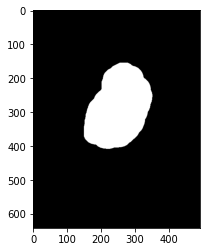

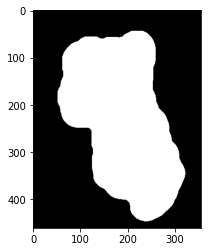

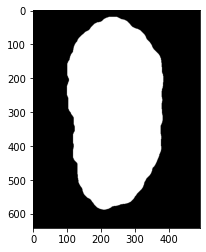

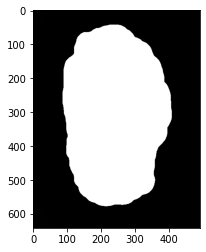

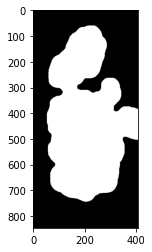

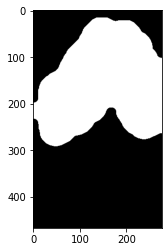

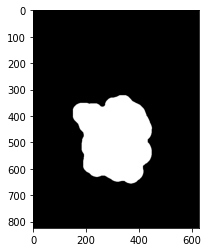

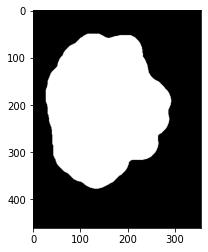

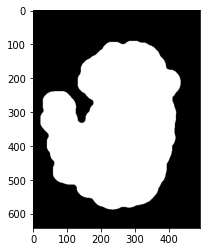

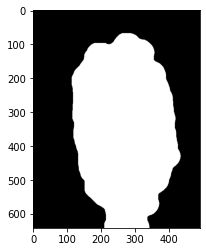

In [ ]:
apply_closing('melanoma')

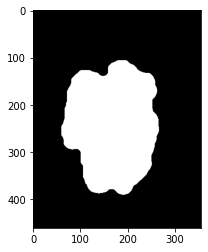

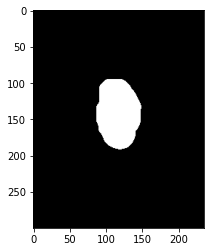

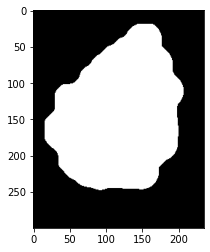

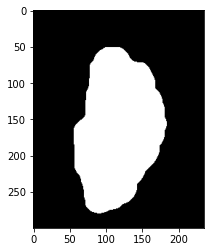

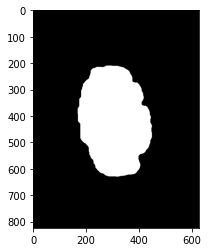

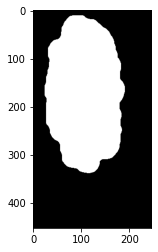

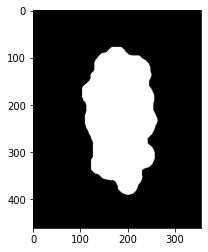

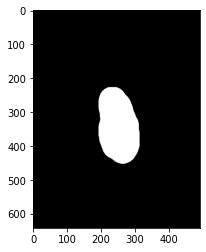

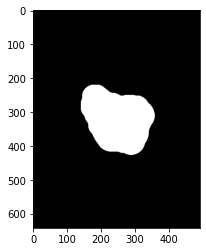

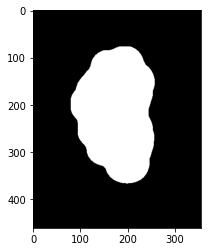

In [ ]:
apply_closing('nevus')